# SegNet for Cityscapes Segmentation

**Note:** This implementation does not initialise the encoder using pre-trained VGG-16 weights, which is why the performance is lower than would otherwise be expected.

In [1]:
from pathlib import Path
from glob import glob
from copy import copy

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from fastai.vision.all import DataLoader, DataLoaders, Learner

from typing import List, Tuple

In [2]:
BATCH_SIZE = 8
NUM_CLASSES = 34

## Load Data

In [3]:
BASE_DATA_DIR = Path('data')

IMG_DATA_DIR = BASE_DATA_DIR / 'images'
ANN_DATA_DIR = BASE_DATA_DIR / 'annotations'

TRAIN_IMG_DIR = IMG_DATA_DIR / 'train'
VALID_IMG_DIR = IMG_DATA_DIR / 'val'
TEST_IMG_DIR  = IMG_DATA_DIR / 'test'

TRAIN_ANN_DIR = ANN_DATA_DIR / 'train'
VALID_ANN_DIR = ANN_DATA_DIR / 'val'
TEST_ANN_DIR  = ANN_DATA_DIR / 'test'

In [4]:
IMAGENET_MEANS = (0.485, 0.456, 0.406)
IMAGENET_STDS  = (0.229, 0.224, 0.225)

IMAGENET_INV_MEANS = (-2.118, -2.036, -1.804)
IMAGENET_INV_STDS  = ( 4.367,  4.464,  4.444)

CLASS_COLORS = torch.tensor([
    [  0,   0,   0], [  0,   0,   0], [  0,   0,   0], [  0,   0,   0],
    [  0,   0,   0], [111,  74,   0], [ 81,   0,  81], [128,  64, 128],
    [244,  35, 232], [250, 170, 160], [230, 150, 140], [ 70,  70,  70],
    [102, 102, 156], [190, 153, 153], [180, 165, 180], [150, 100, 100],
    [150, 120,  90], [153, 153, 153], [153, 153, 153], [250, 170,  30],
    [220, 220,   0], [107, 142,  35], [152, 251, 152], [ 70, 130, 180],
    [220,  20,  60], [255,   0,   0], [  0,   0, 142], [  0,   0,  70],
    [  0,  60, 100], [  0,   0,  90], [  0,   0, 110], [  0,  80, 100],
    [  0,   0, 230], [119,  11,  32]
])

class CityscapesDataset(Dataset):
    
    def __init__(self, img_dir: Path, ann_dir: Path, img_width: int,
                 img_height: int, is_train: bool):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.img_width = img_width
        self.img_height = img_height
        self.is_train = is_train
        self.data = []
        
        # Create list of image and annotation paths
        fns = [Path(o) for o in glob(f"{img_dir}/**/**")]
        for image_path in fns:
            color_fn = image_path.name.replace("leftImg8bit", "gtFine_color")
            color_path = ann_dir / image_path.parent.name / color_fn
            
            label_fn = image_path.name.replace("leftImg8bit", "gtFine_labelIds")
            label_path = ann_dir / image_path.parent.name / label_fn
            
            self.data.append({
                "image": image_path,
                "color": color_path,
                "label": label_path,
            })
        
        # Create image transforms
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(IMAGENET_MEANS, IMAGENET_STDS)
        self.denormalize = transforms.Normalize(IMAGENET_INV_MEANS, IMAGENET_INV_STDS)
        self.resize = transforms.Resize((self.img_height, self.img_width),
                                        interpolation=Image.NEAREST)
        
        self.horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
        
        self.random_resized_crop = transforms.RandomResizedCrop(
            (self.img_height, self.img_width), scale=(0.5, 1.0),
            ratio=(0.75, 1.33), interpolation=Image.NEAREST)
        
        self.random_affine = transforms.RandomAffine(degrees=10, shear=10,
                                                     resample=Image.NEAREST)
        
        self.color_jitter = transforms.ColorJitter(brightness=0.30, contrast=0.50,
                                                   saturation=0.50, hue=0.20)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        datum = self.data[idx]
        img_path = datum["image"]
        lbl_path = datum["label"]

        img = Image.open(img_path)
        lbl = Image.open(lbl_path)
        
        # Group image and annotation into a single tensor so that all
        # transformations are applied equally to both
        img = self.to_tensor(img)
        lbl = self.to_tensor(lbl)
        
        img_channels = img.size(0)
        t = torch.cat([img, lbl], dim=0)
        if self.is_train:
            t = self.horizontal_flip(t)
            t = self.random_resized_crop(t)
            t = self.random_affine(t)
        else:
            t = self.resize(t)
        
        # Recover image and annotation from concatenated tensor
        img = t[:img_channels]
        if self.is_train:
            img = self.color_jitter(img)
        img = self.normalize(img)
        
        lbl = t[img_channels:]
        lbl = (lbl * 255 + 1e-4).long()
        
        return img, lbl
    
    def show(self, img: torch.Tensor, targ: torch.Tensor = None, pred: torch.Tensor = None):
        img = self.denormalize(img).clamp(min=0, max=1)
        if targ is not None: targ = self.color_tensor(targ)
        if pred is not None: pred = self.color_tensor(pred)
        tensors_to_show = [t for t in (img, targ, pred) if t is not None]
        num_axes = len(tensors_to_show)
        
        fig, axs = plt.subplots(1, num_axes, figsize=(6 * num_axes, 3 * num_axes))
        fig.subplots_adjust(wspace=0.03)
        
        for ax, t in zip(axs, tensors_to_show):
            self.show_ax(ax, t)
        plt.show()
    
    def color_tensor(self, t: torch.Tensor) -> torch.Tensor:
        t = t.squeeze(0)
        t = F.one_hot(t, num_classes=NUM_CLASSES) @ CLASS_COLORS
        t = t.permute(2, 0, 1)
        return t
    
    @staticmethod
    def show_ax(ax, img: torch.Tensor):
        ax.imshow(img.numpy().transpose(1, 2, 0))
        ax.axis('off')

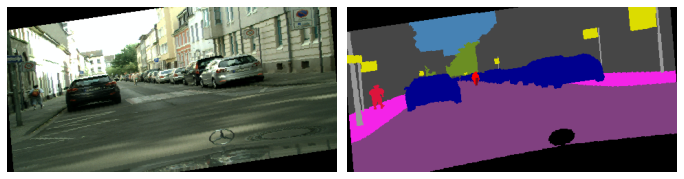

In [5]:
train_ds = CityscapesDataset(TRAIN_IMG_DIR, TRAIN_ANN_DIR, 480, 240, True)
valid_ds = CityscapesDataset(VALID_IMG_DIR, VALID_ANN_DIR, 480, 240, False)
test_ds  = CityscapesDataset(TEST_IMG_DIR,  TEST_ANN_DIR,  480, 240, False)

img, lbl = train_ds[0]
train_ds.show(img, lbl)

In [6]:
train_dl = DataLoader(train_ds, bs=BATCH_SIZE, num_workers=32, pin_memory=True, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=BATCH_SIZE, num_workers=32, pin_memory=True, shuffle=True)
test_dl = DataLoader(valid_ds, bs=BATCH_SIZE, num_workers=32, pin_memory=True, shuffle=True)
dls = DataLoaders(train_dl, valid_dl).cuda()
test_dl.to('cuda')

## Define Model Architecture

In [7]:
class ConvBNReLU(nn.Sequential):
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, dropout_p: float):
        padding = kernel_size // 2 # Same padding
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        if dropout_p: layers.append(nn.Dropout(dropout_p, inplace=True))
        layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [8]:
class EncoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels: int, num_layers: int,
                 kernel_size: int, dropout_p: float = 0.0):
        super().__init__()
        self.conv = nn.Sequential(
            ConvBNReLU(in_channels, out_channels, kernel_size, dropout_p),
            *[ConvBNReLU(out_channels, out_channels, kernel_size, dropout_p) for _ in range(num_layers - 1)]
        )
        
        self.max_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
    
    def forward(self, inp: Tuple[torch.Tensor, torch.Tensor, List[torch.Size]]):
        x, all_pool_idxs, output_sizes = inp
        x = self.conv(x)
        output_sizes.append(x.shape)
        x, pool_idxs = self.max_pool(x)
        all_pool_idxs.append(pool_idxs)
        return x, all_pool_idxs, output_sizes

In [9]:
class DecoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels: int, num_layers: int,
                 kernel_size: int, dropout_p: float = 0.0):
        super().__init__()
        self.max_unpool = nn.MaxUnpool2d(2, stride=2)

        self.conv = nn.Sequential(
            *[ConvBNReLU(in_channels, in_channels, kernel_size, dropout_p) for _ in range(num_layers - 1)],
            ConvBNReLU(in_channels, out_channels, kernel_size, dropout_p),
        )
    
    def forward(self, inp: Tuple[torch.Tensor, torch.Tensor, List[torch.Size]]):
        x, all_pool_idxs, output_sizes = inp
        pool_idxs = all_pool_idxs.pop()
        output_size = output_sizes.pop()
        x = self.max_unpool(x, pool_idxs, output_size=output_size)
        x = self.conv(x)
        return x, all_pool_idxs, output_sizes

In [10]:
class SegNet(nn.Module):
    
    def __init__(self, channels: List[int], dropout_probs: List[int], layers: List[int],
                 kernel_size: int, decoder_out_channels: int, num_classes: int):
        super().__init__()
        self.num_classes = num_classes
        
        enc_in_channels  = copy(channels[:-1])
        enc_out_channels = copy(channels[1:])
        enc_layers = layers
        encoder_block_data = zip(enc_in_channels, enc_out_channels,
                                 enc_layers, dropout_probs)
        self.encoder = nn.Sequential(*[
            EncoderBlock(in_channels, out_channels, num_layers, kernel_size, dropout_p)
            for in_channels, out_channels, num_layers, dropout_p in encoder_block_data
        ])
        
        channels = channels[::-1]
        dec_in_channels  = copy(channels[:-1])
        dec_out_channels = copy([*channels[1:-1], decoder_out_channels])
        dec_layers = layers[::-1]
        decoder_block_data = zip(dec_in_channels, dec_out_channels,
                                 dec_layers, dropout_probs[::-1])
        self.decoder = nn.Sequential(*[
            DecoderBlock(in_channels, out_channels, num_layers, kernel_size, dropout_p)
            for in_channels, out_channels, num_layers, dropout_p in decoder_block_data
        ])
        
        self.classifier = nn.Conv2d(decoder_out_channels, self.num_classes, kernel_size=1)
    
    def forward(self, x: torch.Tensor):
        enc_in = (x, [], [])
        enc_out = self.encoder(enc_in)
        dec_out, _, _ = self.decoder(enc_out)
        cls_out = self.classifier(dec_out)
        return cls_out

## Train Model

In [11]:
CHANNELS = [3, 64, 128, 256, 512, 512]
DROPOUT_PROBS = [0.0, 0.0, 0,0, 0.5, 0.5]
DECODER_OUT_CHANNELS = 64
LAYERS = [2, 2, 3, 3, 3]
KERNEL_SIZE = 3
WEIGHT_DECAY = 5e-4

segnet = SegNet(CHANNELS, DROPOUT_PROBS, LAYERS, KERNEL_SIZE, DECODER_OUT_CHANNELS, NUM_CLASSES)
segnet.cuda();

In [12]:
cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean')

def loss_func(preds: torch.Tensor, targs: torch.Tensor) -> torch.Tensor:
    """Cross entropy loss between pixel class predictions and targets"""
    preds = preds.flatten(2)
    targs = targs.flatten(1)
    loss = cross_entropy_loss(preds, targs)
    return loss

def global_accuracy(preds: torch.Tensor, targs: torch.Tensor) -> torch.Tensor:
    preds = preds.detach().flatten(2).argmax(1)
    targs = targs.flatten(1)
    
    global_acc = (preds == targs).float().mean()
    return global_acc.item()

def get_one_hot_tensor(t: torch.Tensor) -> torch.Tensor:
    one_hot = F.one_hot(t, num_classes=NUM_CLASSES)
    one_hot = one_hot.reshape(-1, NUM_CLASSES)
    return one_hot

def class_avg_accuracy(preds: torch.Tensor, targs: torch.Tensor) -> torch.Tensor:
    preds = preds.flatten(2).argmax(1)
    targs = targs.flatten(1)

    one_hot_preds = get_one_hot_tensor(preds)
    one_hot_targs = get_one_hot_tensor(targs)

    class_tps = (one_hot_preds & one_hot_targs).float().sum(0)
    class_tps_fns = one_hot_targs.float().sum(0)
    class_tps_fns = class_tps_fns.clamp(min=1e-6) # Clamp in case there are zeros
    class_accuracies = class_tps / class_tps_fns
    class_avg_acc = class_accuracies.mean()
    return class_avg_acc.item()

def mean_iou(preds: torch.Tensor, targs: torch.Tensor) -> torch.Tensor:
    preds = preds.flatten(2).argmax(1)
    targs = targs.flatten(1)
    
    one_hot_preds = get_one_hot_tensor(preds)
    one_hot_targs = get_one_hot_tensor(targs)

    tps = (one_hot_preds & one_hot_targs).float().mean(0)
    tps_fps_fns = (one_hot_preds | one_hot_targs).float().mean(0)
    tps_fps_fns = tps_fps_fns.clamp(min=1e-6) # Clamp in case there are zeros
    iou = tps / tps_fps_fns
    return iou.mean().item()

In [13]:
learn = Learner(
    dls, segnet,
    loss_func=loss_func,
    metrics=[global_accuracy, class_avg_accuracy, mean_iou],
    wd=WEIGHT_DECAY,
)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.019054606556892395)

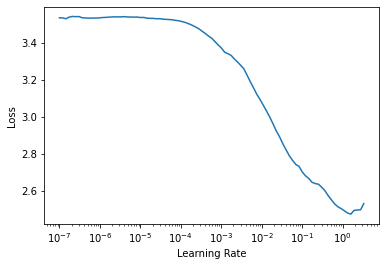

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(500, 1e-2)
learn.save('model')

epoch,train_loss,valid_loss,global_accuracy,class_avg_accuracy,mean_iou,time
0,1.059966,1.278176,0.618085,0.136575,0.085993,01:29
1,0.861644,1.103595,0.682043,0.148774,0.104568,01:27
2,0.817793,0.985010,0.722042,0.164523,0.119533,01:27
3,0.743515,0.997244,0.726566,0.165184,0.123276,01:27
4,0.710043,0.979490,0.725495,0.171498,0.134885,01:27
5,0.669917,0.862157,0.757958,0.195364,0.151172,01:27
6,0.654099,0.883660,0.747995,0.212641,0.156747,01:27
7,0.629544,0.817145,0.772185,0.209665,0.160068,01:27
8,0.633065,0.894739,0.738214,0.203053,0.152944,01:28
9,0.619043,0.866918,0.759702,0.193412,0.154857,01:27


Path('models/model.pth')

## Evaluate Model

In [16]:
learn.load('model')
model = learn.model
model.eval()
model.cuda();

### Display Several Test Set Images

Accuracy: 82.62%


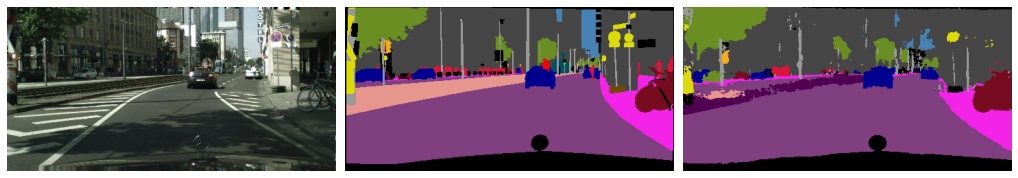

Accuracy: 74.68%


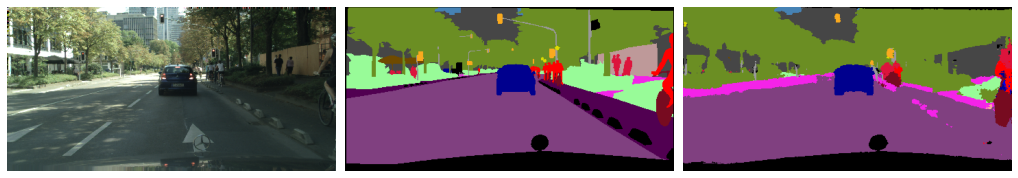

Accuracy: 93.59%


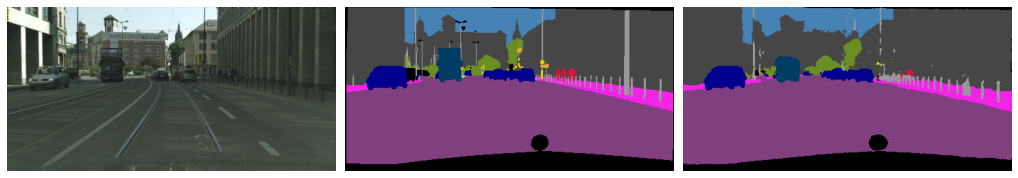

Accuracy: 89.19%


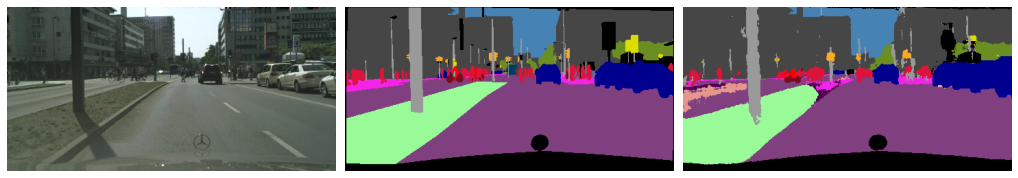

Accuracy: 80.62%


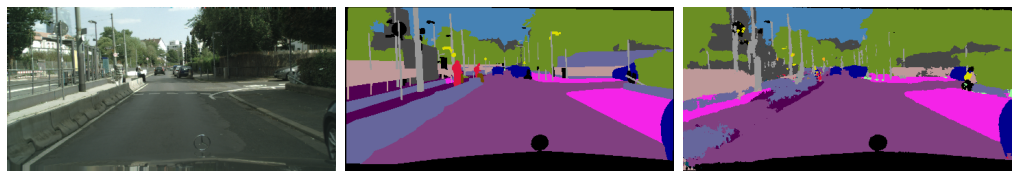

Accuracy: 87.59%


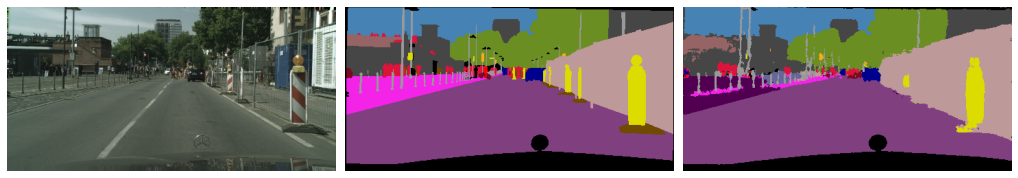

Accuracy: 84.91%


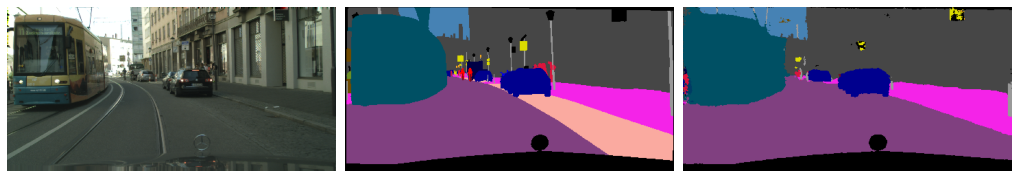

Accuracy: 90.15%


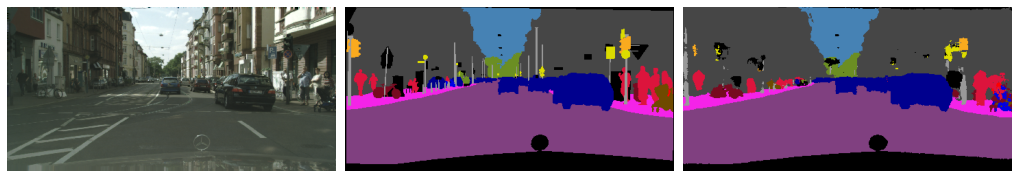

Accuracy: 92.69%


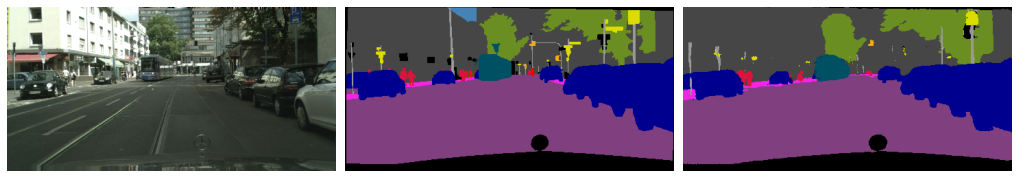

Accuracy: 93.92%


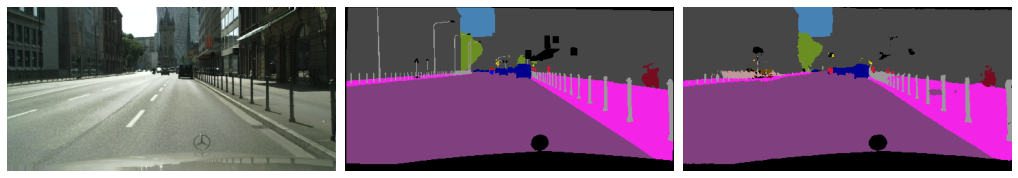

In [17]:
for idx in range(10):
    img, targ = valid_ds[idx]
    pred = learn.model(img[None].cuda()).cpu()
    pred = pred.argmax(dim=1)
    accuracy = (pred == targ).float().mean()
    print(f"Accuracy: {accuracy * 100:.2f}%")

    valid_ds.show(img, targ, pred)

### Evaluate Model on Test Set

In [18]:
global_accs = []
class_avg_accs = []
mean_ious = []

for imgs, targs in test_dl:
    preds = model(imgs)

    global_accs.append(global_accuracy(preds, targs))
    class_avg_accs.append(class_avg_accuracy(preds, targs))
    mean_ious.append(mean_iou(preds, targs))

global_acc = np.mean(global_accs)
class_avg_acc = np.mean(class_avg_accs)
mean_iou_val = np.mean(mean_ious)

print("Test Set Metrics:")
print(f"Global Accuracy: {global_acc:.2f}")
print(f"Class Avg. Accuracy: {class_avg_acc:.2f}")
print(f"Mean IoU: {mean_iou_val:.2f}")

Test Set Metrics:
Global Accuracy: 0.87
Class Avg. Accuracy: 0.39
Mean IoU: 0.33
